In [1]:
import matplotlib.pyplot as plt
import numpy as np

import galaxy_tools as gal
import general_tools as gen

from firestudio.utils.stellar_utils import raytrace_projection

%matplotlib inline


Couldn't import numba. Missing:
abg_python.all_utils.get_cylindrical_velocities
Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


In [2]:
sim = 'm12_elvis_RomulusRemus_res4000'

snap_num = 600

# path to the directory holding the simulation snapshot 
sim_path =  '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/output/hdf5/snapdir_'+str(snap_num)+'/'

# path to the directory holding the halo files for the simulation
halo_path = '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/halo/rockstar_dm/hdf5/'


In [3]:
# This loads the halo file
# host=True means it only returns the host halo information, otherwise it returns all the halos
# filetype='hdf5' indicate the halo file type, some halos are filetype='ascii'
# hostnumber indicates which host halo you are looking at. Only need to worry about this for the elvis pairs.
        #use hostnumber=2 to get the halo info for the second host halo. 
        #ex: halo_themla = gal.load_halo(halo_path, snap_num, host=True, filetype='ajk\23hdf5', hostnumber=1)
        #    halo_louise = gal.load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=2)


halo = gal.load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=2)


In [4]:
# This loads the star and gas particle
# It only loads the parameters I need for the mock images

star_snapdict, gas_snapdict = gal.load_sim(sim_path,snap_num)


In [5]:
# This centers star and gas dictionaries on the host halo
# If orient=True, then it will rotate the particles based on the disk orientation
# If lim=True, then it masks out the particles beyond the limvalue
    # Have lim=False if you want to carry around all the particles
    # I chose to mask out particles beyond the virial radius

limvalue = halo['Halfmass_Radius'].values[0]/3

star_snapdict, gas_snapdict, halo = gal.mask_sim_to_halo(star_snapdict=star_snapdict,
                                                         gas_snapdict=gas_snapdict, 
                                                         host_halo=halo, 
                                                         orient=True,
                                                         lim = True,
                                                         limvalue = limvalue
                                                        )


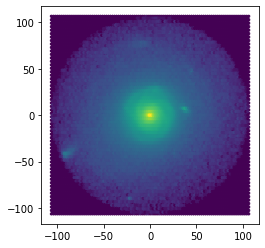

In [6]:
plt.hexbin(star_snapdict['Coordinates'][:,0],star_snapdict['Coordinates'][:,1], bins='log')
plt.gca().set_aspect(1)

In [7]:
# mass_scaler: The code expects the masses to be in the simulation units of 1e10 Msun.
              #if the mass is in units Msun (which it is for the snapdict), 
              #then use mass_scaler = 1e-10
        
# bands: The code will determine the luminosity in 3 bands because the main goal of this code
        #is to make the a composite image. 
        #Band options are:     
        #    0  - Absolute mag
        #    1  - SDSS u (unprimed AB)
        #    2  - SDSS g (unprimed AB)
        #    3  - SDSS r (unprimed AB)
        #    4  - SDSS i (unprimed AB)
        #    5  - SDSS z (unprimed AB)
        #    6  - U (BESSEL)
        #    7  - B (BESSEL)
        #    8  - V (BESSEL)
        #    9  - R (KPNO)
        #    10 - I (KPNO)
        #    11 - J (BESSEL)
        #    12 - H (BESSEL)
        #    13 - K (BESSEL)
        #For my research I usually use u, g, r

mass_scaler = 1e-10
bands = [1,2,3]


#lums is the luminosity of each particle in units of 1e-10 Lsum
#kappa has to do with the opacity of the band

kappas,lums = raytrace_projection.read_band_lums_from_tables([1,2,3],
                                                             star_snapdict['Masses']*mass_scaler,
                                                             star_snapdict['StellarAge'],
                                                             star_snapdict['Metallicity'])


# The lums output units are in 1e-10 Lsum
unit_factor = 1e10 # gives units in Lsun
lums[0], lums[1], lums[2] = lums[0]*unit_factor, lums[1]*unit_factor, lums[2]*unit_factor



Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)


In [8]:
# To get the Half light radius use radius_of_param_limit
# For more information use gal.radius_of_param_limit?

r_50, l_50 = gen.radius_of_param_limit(radii=star_snapdict['r_xy'], 
                                       parameter=lums[0], 
                                       limits=[.5], 
                                       limit_type='param_fraction')
print(r_50, l_50)

[5.042081312238657] [34109023036.648773]


In [9]:
# If you also want the mock image use this method
# The output of thus function is the composite image, 
# and the array of the surface brightness in each band 

#Field of view for the image in kpc
FOV = limvalue
#Number 0f pixels
pixels= 100
# the axis it is projected on, 'xy', 'yz', 'zx'
view = 'xy' 
# use the center of mass or center of light, 'light', 'mass'
center = 'light'
# the limiting surface brightness, if you dont want to limit it set it equal to zero
minden = gen.mag_to_lum_SB(29,None) # I set it to 29 mag/arcsec^2. This function convers it to lum/kpc^2


image,out_band0,out_band1,out_band2 = gal.get_mock_observation(star_snapdict,
                                                               gas_snapdict,
                                                               bands = [1,2,3],
                                                               FOV=FOV,
                                                               mass_scaler = 1e-10,
                                                               pixels=pixels,
                                                               view='xy',
                                                               minden = minden,
                                                               center = center
                                                            )

Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [6.82182516 3.76026353 2.84335234]
opacity in each band: [1585.97915621 1154.44253194  799.38644653]
total gas mass: 3.4466169058495524
maxden ==  83401687.7196553  dynrange ==  912.7983347788378  minden ==  91369.23736814522


/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:129: RuntimeWarning: divide by zero encountered in log10
  f_i = np.log10(i/minnorm) / np.log10(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:137: RuntimeWarning: divide by zero encountered in log
  r = np.log(r/minnorm) / np.log(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:138: RuntimeWarning: divide by zero encountered in log
  g = np.log(g/minnorm) / np.log(maxnorm/minnorm);
/export/nfs0home/kleinca/fire_tools/FIRE_studio/firestudio/utils/stellar_utils/make_threeband_image.py:139: RuntimeWarning: divide by zero encountered in log
  b = np.log(b/minnorm) / np.log(maxnorm/minnorm);


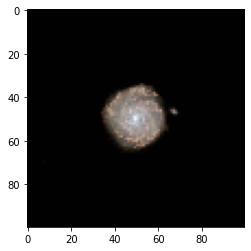

In [10]:
plt.imshow(image)